# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

In [2]:
# Add-on : Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

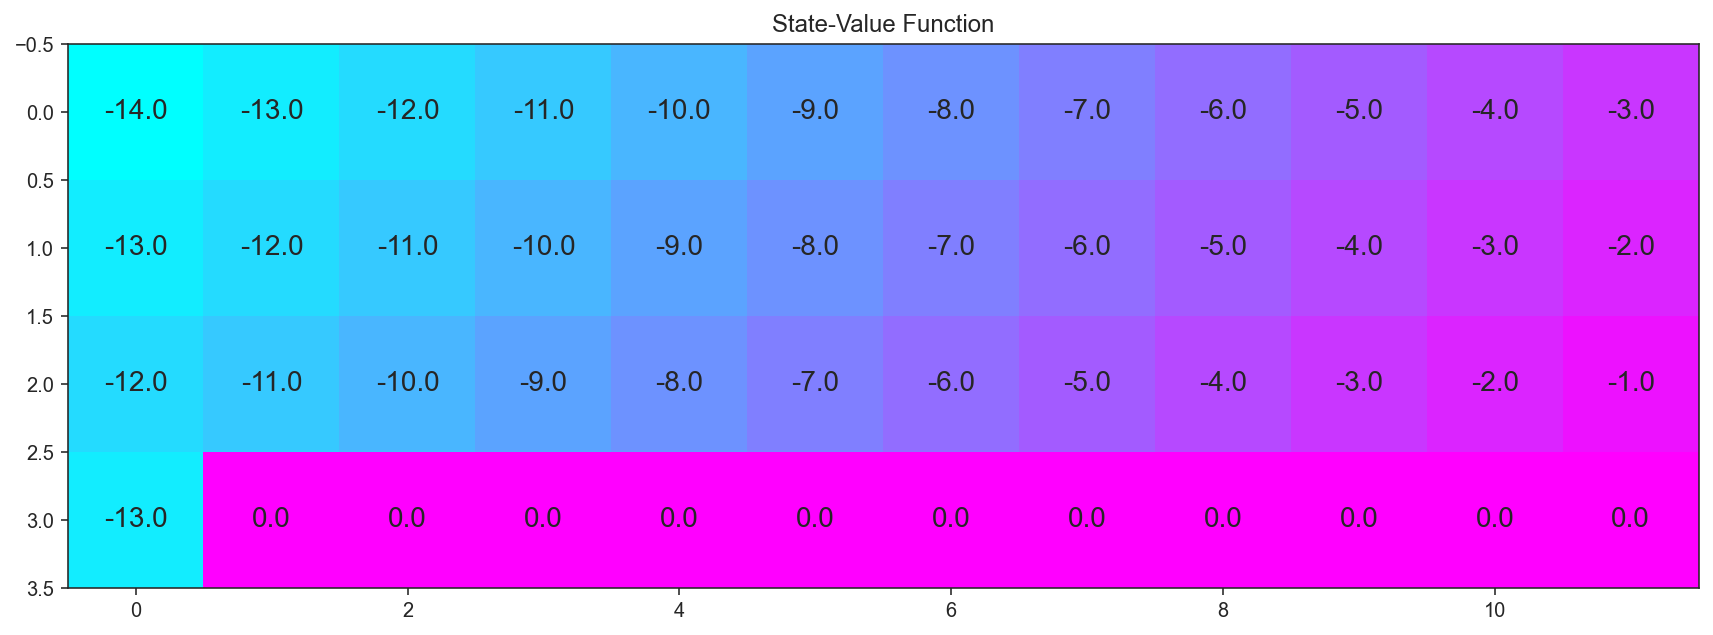

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def select_greedy_action(Q, state, nA, epsilon):
    """Select an epsilon-greedy action for the current state."""

    if np.random.random() > epsilon:
        # Select the greedy action
        return np.argmax(Q[state])
    else:
        # Select randomly an action
        return np.random.choice(np.arange(nA))
    
    
def update_Q_sarsa(Q, alpha, gamma, state, action, reward, next_state=None, next_action=None):
    """ updates the Q-Table (action-value function estimate) using the most recent episode """
        
    # Backup current Q for state, action
    Qsa = Q[state][action]      
    # Retrieve Q for next_state, next action (If end of episode / next_state is None, then return 0)
    Qsa_next = Q[next_state][next_action] if next_state is not None  else 0
    # Update the Q-Table
    Qsa = Qsa + alpha * (reward + gamma * Qsa_next - Qsa)
    return Qsa


def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor
    # See https://docs.python.org/3.6/library/collections.html#collections.deque
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # Initialize environment
        state = env.reset()
        score =0
         
        # Select an available action for the state by following the epsilon-greedy policy 
        epsilon = 1.0 / i_episode
        action = select_greedy_action(Q, state, env.nA, epsilon)

        # Loop until the episode terminates
        while True:
  
            # Take the action and update the episode
            next_state, reward, done, info = env.step(action)
        
            # Update the score of the agent with the current reward
            score  += reward
        
            if not done:
                # Select the next action for the state by following the epsilon-greedy policy 
                next_action = select_greedy_action(Q, next_state, env.nA, epsilon)
                # Update the Q_table
                Q[state][action] = update_Q_sarsa(Q, alpha, gamma, state, action, reward, next_state, next_action)
                
                # Update state and action
                state = next_state
                action = next_action
              
            else:  # The episode is finished

                # Update the Q_table
                Q[state][action] = update_Q_sarsa(Q, alpha, gamma, state, action, reward)
                
                # Backup the agent's score
                tmp_scores.append(score)
                break
        
        # Compute Average scores statistics
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores),
             color='magenta')
    plt.xlabel('Episode Number', color='magenta')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every, color='magenta')
    plt.tick_params(axis='x', colors='magenta')
    plt.tick_params(axis='y', colors='magenta')
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 50000/50000

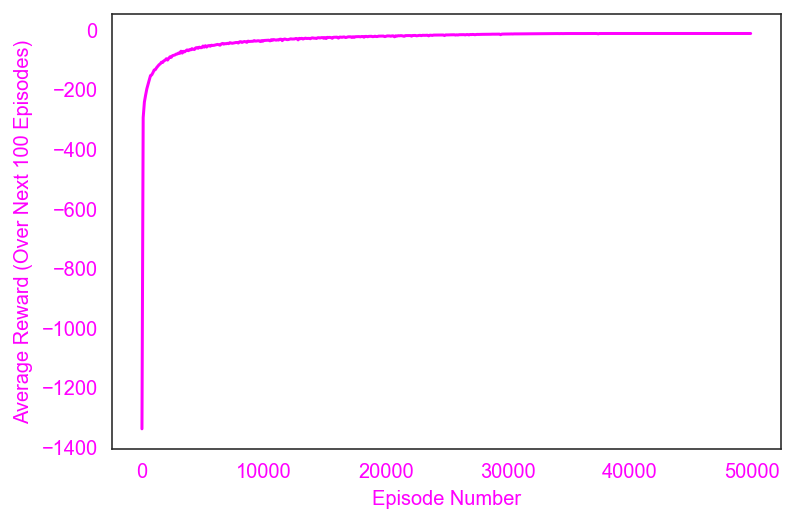

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  3  1  1  2  3  0  1  1  1  2  2]
 [ 3  1  1  1  2  1  1  1  1  0  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


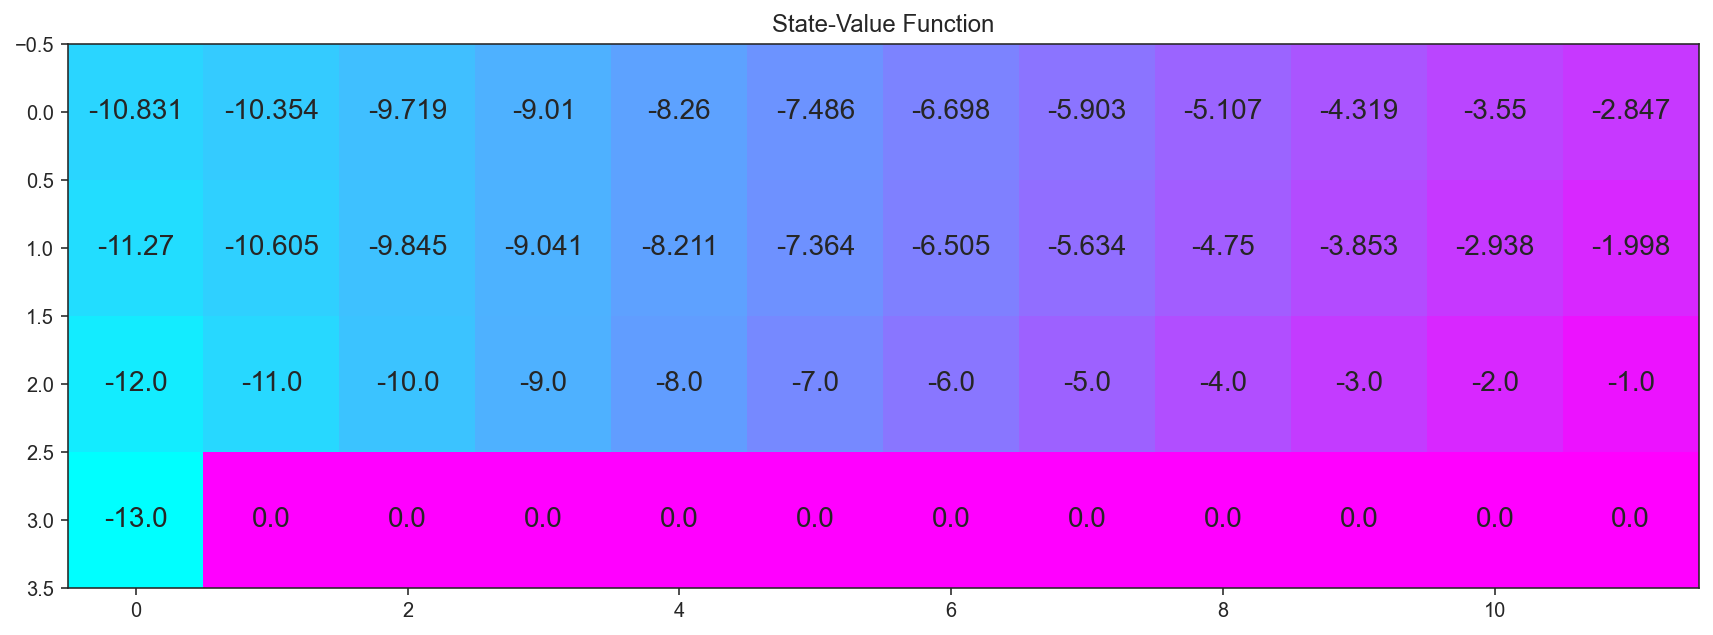

In [16]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 50000, .001)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [17]:
# select_greedy_action is identical as in Part 1
def select_greedy_action(Q, state, nA, epsilon):
    """Select an epsilon-greedy action for the current state."""

    if np.random.random() > epsilon:
        # Select the greedy action
        return np.argmax(Q[state])
    else:
        # Select randomly an action
        return np.random.choice(np.arange(nA))
    
    
def update_Q_sarsamax(Q, alpha, gamma, state, action, reward, next_state=None):
    """ updates the Q-Table (action-value function estimate) using the most recent episode """
     
    # Backup current Q for state, action
    Qsa = Q[state][action]      
    # Retrieve highest Q estimate for next_state (If end of episode / next_state is None, then return 0)
    Qsa_next = np.max(Q[next_state]) if next_state is not None  else 0
    # Update the Q-Table
    Qsa = Qsa + alpha * ((reward + gamma * Qsa_next) - Qsa)
    return Qsa

def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor
    # See https://docs.python.org/3.6/library/collections.html#collections.deque
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # Initialize environment
        state = env.reset()
        score = 0
        
        # set epsilon por the epsilon-greedy policy 
        epsilon = 1.0 / i_episode

        # Loop until the episode terminates
        while True:
            
            # Select an available action for the state by following the epsilon-greedy policy 
            action = select_greedy_action(Q, state, env.nA, epsilon)
  
            # Take the action and update the episode
            next_state, reward, done, info = env.step(action)
        
            # Update the score of the agent with the current reward
            score += reward
            
            # Update the Q_table
            Q[state][action] = update_Q_sarsamax(Q, alpha, gamma, state, action, reward, next_state)

            # Update state 
            state = next_state
        
            if done: # The episode is finished       
                # Backup the agent's score
                tmp_scores.append(score)
                break
        
        # Compute Average scores statistics
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores),
             color='magenta')
    plt.xlabel('Episode Number', color='magenta')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every, color='magenta')
    plt.tick_params(axis='x', colors='magenta')
    plt.tick_params(axis='y', colors='magenta')
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
        
    return Q


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 100/100

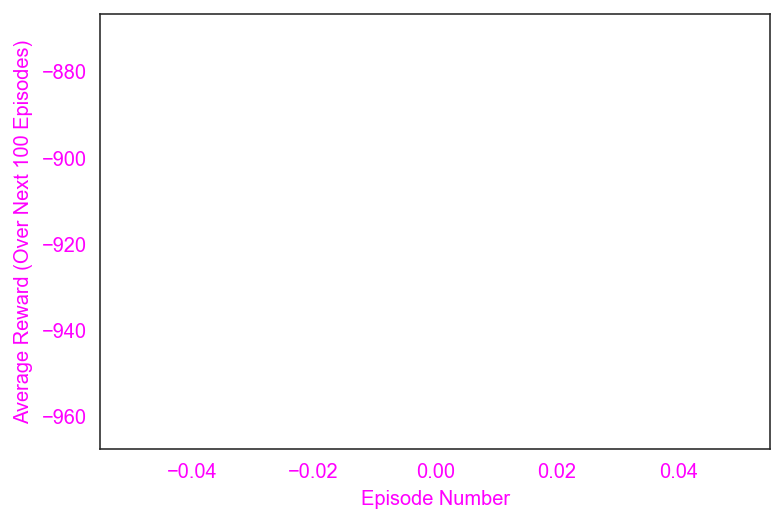

Best Average Reward over 100 Episodes:  -917.11


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  1  1  1  2  1  0  1  2  2]
 [ 1  2  1  1  1  1  2  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


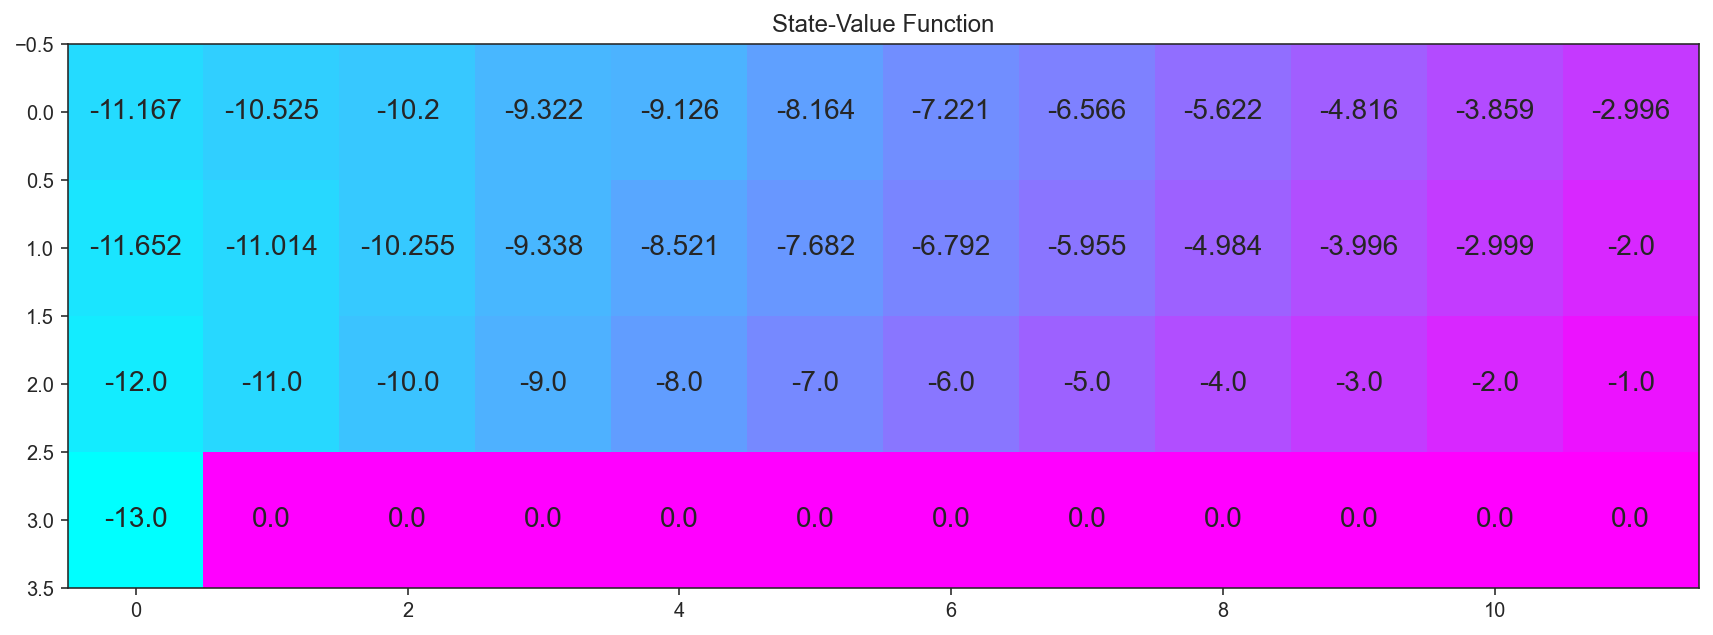

In [28]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 100, 0.8)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [19]:
# select_greedy_action is identical as in Part 1
def select_greedy_action(Q, state, nA, epsilon):
    """Select an epsilon-greedy action for the current state."""

    if np.random.random() > epsilon:
        # Select the greedy action
        return np.argmax(Q[state])
    else:
        # Select randomly an action
        return np.random.choice(np.arange(nA))
    
def get_action_probs(Qs, epsilon, nA):
    """" Get the action probabilities for the epsilon-greedy policy"""
    
    # With probability epsilon, the agent will select an action uniformly 
    # at random from the set of available (non-greedy AND greedy) actions
    pi_s = np.ones(nA) * epsilon / nA
    
    # With probability (1 - epsilon), the agent will select the greedy action
    best_a = np.argmax(Qs)
    pi_s[best_a] = (1 - epsilon) + (epsilon / nA)
    
    return pi_s
 
    
def update_Q_expected_sarsa(Q, alpha, gamma, state, action, reward, epsilon, nA, next_state=None):
    """ updates the Q-Table (action-value function estimate) using the most recent episode """
                
    # Backup current Q for state, action
    Qsa = Q[state][action]      
    # Retrieve the expected value for the next_state (If end of episode / next_state is None, then return 0)
    Qsa_next = np.dot(Q[next_state],get_action_probs(Q[next_state], epsilon, nA)) if next_state is not None  else 0
    # Update the Q-Table
    Qsa = Qsa + alpha * ((reward + gamma * Qsa_next) - Qsa)
    return Qsa



def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # initialize performance monitor
    # See https://docs.python.org/3.6/library/collections.html#collections.deque
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # Initialize environment
        state = env.reset()
        score = 0
        
        # set epsilon por the epsilon-greedy policy 
        #epsilon = 1.0 / i_episode  ==> Does not provide good results in this case
        epsilon = 0.005 


        # Loop until the episode terminates
        while True:
            
            # Select an available action for the state by following the epsilon-greedy policy 
            action = select_greedy_action(Q, state, env.nA, epsilon)
  
            # Take the action and update the episode
            next_state, reward, done, info = env.step(action)
        
            # Update the score of the agent with the current reward
            score += reward
            
            # Update the Q_table
            Q[state][action] = update_Q_expected_sarsa(Q, alpha, gamma, state, action, reward, epsilon, env.nA, next_state)

            # Update state 
            state = next_state
        
            if done: # The episode is finished       
                # Backup the agent's score
                tmp_scores.append(score)
                break
        
        # Compute Average scores statistics
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores),
             color='magenta')
    plt.xlabel('Episode Number', color='magenta')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every, color='magenta')
    plt.tick_params(axis='x', colors='magenta')
    plt.tick_params(axis='y', colors='magenta')
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 100/100

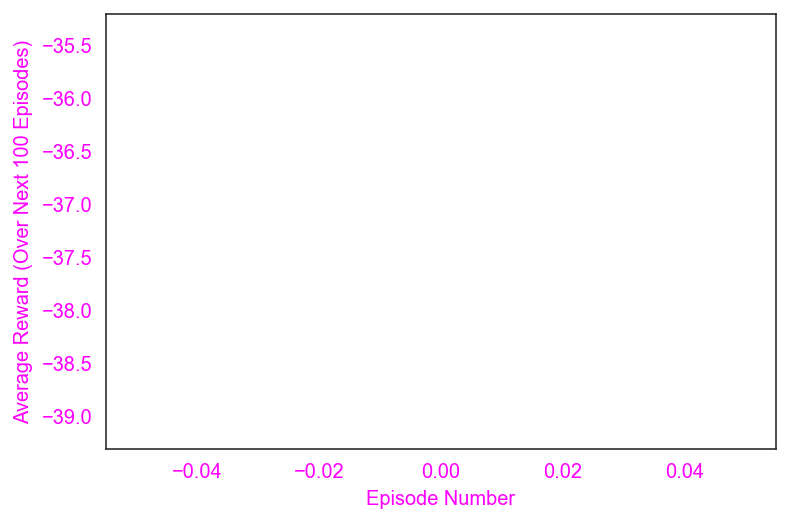

Best Average Reward over 100 Episodes:  -37.26


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  1  0  1  1  3  2  1  1  2]
 [ 1  2  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


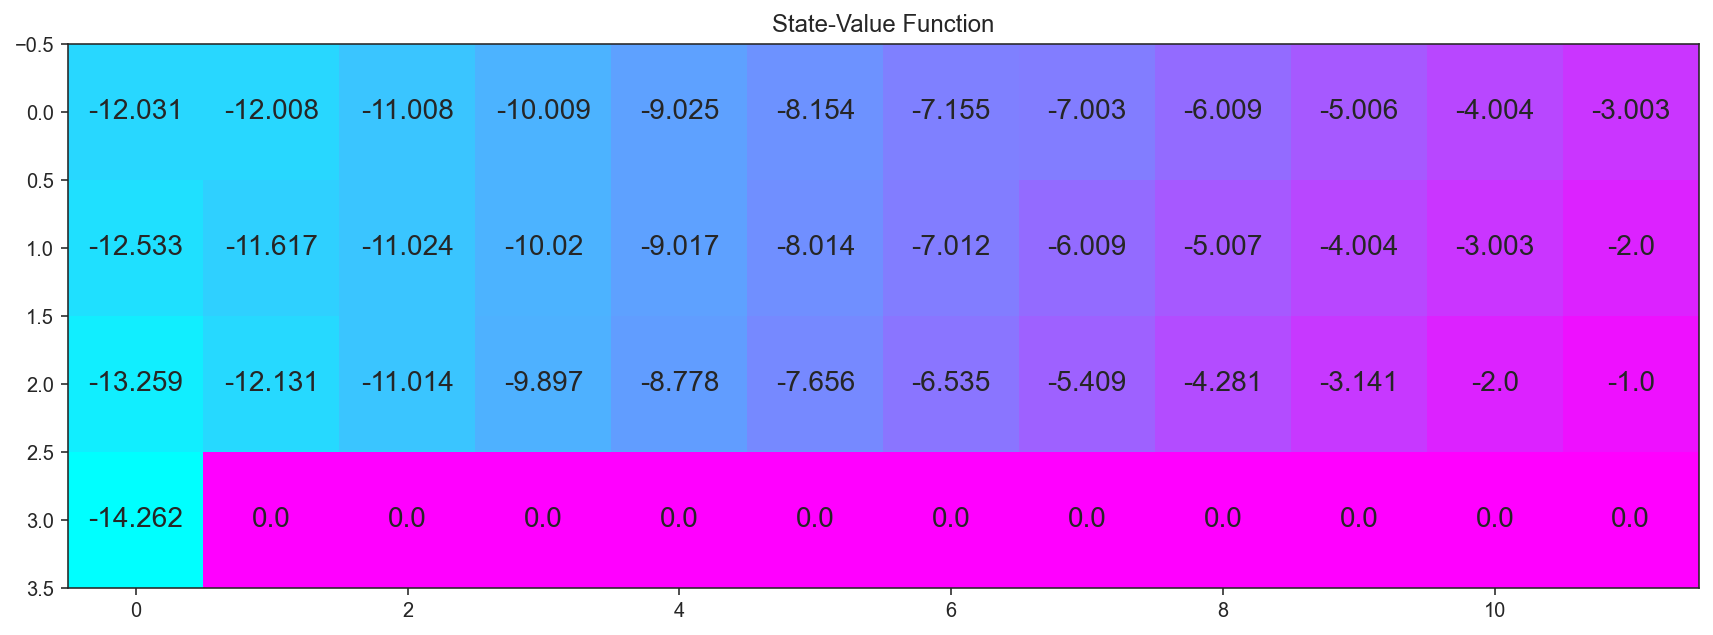

In [27]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_expsarsa = expected_sarsa(env, 10000, 1)
Q_expsarsa = expected_sarsa(env, 100, 1)


# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])